### **Importing the Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from yellowbrick.cluster import silhouette_visualizer
from sklearn.preprocessing import StandardScaler

In [154]:
telecom = pd.read_csv('telecom_customer_segmentation.csv')

In [155]:
telecom

,Region,Gender,SubscriptionType,InternetUsageType,CustomerSupportCalls,ContractType,MonthlyCharges,TotalCharges,CallMinutesPerMonth,InternetGBPerMonth,NumberOfSMSPerMonth,TenureMonths,Age
0,West,Other,Postpaid,Light,High,Monthly,28.06,718.32,537.64,23.55,58.0,23,74
1,Central,Male,Postpaid,Heavy,High,Quarterly,42.99,1164.18,565.91,29.16,69.0,3,23
2,East,Male,Prepaid,Light,Medium,Quarterly,60.06,1165.59,692.74,32.57,94.0,6,66
3,Central,Female,Prepaid,Light,Medium,Monthly,31.96,542.34,564.78,24.59,114.0,16,74
4,Central,Male,Postpaid,Moderate,Medium,Monthly,56.74,751.81,592.89,52.61,81.0,7,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,North-East,Female,Postpaid,Moderate,High,Monthly,67.14,1080.51,566.05,33.51,53.0,26,54
99996,Central,Female,Postpaid,Moderate,High,Quarterly,79.36,776.31,640.90,24.73,110.0,51,27
99997,West,Female,Prepaid,Moderate,Low,Quarterly,61.02,1003.09,536.94,35.89,79.0,36,48
99998,North,Male,Postpaid,Moderate,High,Yearly,31.73,1095.84,617.08,30.14,134.0,45,79


### **Data Preprocessing**

A telecom company wants to segment its customer base services and offers. The goal is to offer similar services 

In [156]:
# Null Values
telecom.isnull().sum()

Region                  0
Gender                  0
SubscriptionType        0
InternetUsageType       0
CustomerSupportCalls    0
ContractType            0
MonthlyCharges          0
TotalCharges            0
CallMinutesPerMonth     0
InternetGBPerMonth      0
NumberOfSMSPerMonth     0
TenureMonths            0
Age                     0
dtype: int64

In [157]:
# Duplicated Values
telecom[telecom.duplicated()]

,Region,Gender,SubscriptionType,InternetUsageType,CustomerSupportCalls,ContractType,MonthlyCharges,TotalCharges,CallMinutesPerMonth,InternetGBPerMonth,NumberOfSMSPerMonth,TenureMonths,Age


In [158]:
telecom.Gender.value_counts()

Gender
Male      33477
Female    33318
Other     33205
Name: count, dtype: int64

### **One Hot Encoding**

In [159]:
telecom.select_dtypes(include="object").columns

Index(['Region', 'Gender', 'SubscriptionType', 'InternetUsageType',
       'CustomerSupportCalls', 'ContractType'],
      dtype='object')

In [160]:
cat = telecom.select_dtypes(include="object").columns

In [161]:
# Checking different numbers of unique values in each category
for i in cat:
    print(telecom[i].unique())

['West' 'Central' 'East' 'South' 'North-East' 'North']
['Other' 'Male' 'Female']
['Postpaid' 'Prepaid']
['Light' 'Heavy' 'Moderate']
['High' 'Medium' 'Low']
['Monthly' 'Quarterly' 'Yearly']


In [162]:
# Encoding Columns
# 1st Region has 6 unique values and are nominal in nature using One-Hot Encoding
pd.get_dummies(telecom['Region']).astype('int64') # Astype is used to convert bool to numberic

,Central,East,North,North-East,South,West
0,0,0,0,0,0,1
1,1,0,0,0,0,0
2,0,1,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
99995,0,0,0,1,0,0
99996,1,0,0,0,0,0
99997,0,0,0,0,0,1
99998,0,0,1,0,0,0


In [163]:
# Adding the encoded columns and dropping the actual columns i.e. Region
telecom = pd.concat([pd.get_dummies(telecom['Region']).astype('int64'),telecom], axis=1)
telecom.drop('Region', axis=1, inplace=True)

In [164]:
telecom = pd.concat([pd.get_dummies(telecom['Gender']).astype('int64'),telecom], axis=1)
telecom.drop('Gender', axis=1, inplace=True)

In [165]:
telecom = pd.concat([pd.get_dummies(telecom['ContractType']).astype('int64'),telecom], axis=1)
telecom.drop('ContractType', axis=1, inplace=True)

In [166]:
telecom['CustomerSupportCalls'].unique()

array(['High', 'Medium', 'Low'], dtype=object)

In [167]:
# Columns: CustomerSupport Calls, InternetUsageType are ordinal in nature so we are using the label encoding using the lambda function
telecom['CustomerSupportCalls'] = telecom['CustomerSupportCalls'].apply(lambda x : 3 if x == 'High' else 2 if x == 'Medium' else 1)

In [168]:
# Columns: CustomerSupport Calls, InternetUsageType are ordinal in nature so we are using the label encoding using the lambda function
telecom['InternetUsageType'] = telecom['InternetUsageType'].apply(lambda x : 3 if x == 'Heavy' else 2 if x == 'Moderate' else 1)

In [169]:
telecom['SubscriptionType'] = telecom['SubscriptionType'].apply(lambda x : 1 if x == 'Postpaid' else 0)

In [170]:
telecom['CustomerSupportCalls'].unique()

array([3, 2, 1])

In [171]:
pd.set_option('display.max_columns', None)

In [172]:
telecom.head()

,Monthly,Quarterly,Yearly,Female,Male,Other,Central,East,North,North-East,South,West,SubscriptionType,InternetUsageType,CustomerSupportCalls,MonthlyCharges,TotalCharges,CallMinutesPerMonth,InternetGBPerMonth,NumberOfSMSPerMonth,TenureMonths,Age
0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,3,28.06,718.32,537.64,23.55,58.0,23,74
1,0,1,0,0,1,0,1,0,0,0,0,0,1,3,3,42.99,1164.18,565.91,29.16,69.0,3,23
2,0,1,0,0,1,0,0,1,0,0,0,0,0,1,2,60.06,1165.59,692.74,32.57,94.0,6,66
3,1,0,0,1,0,0,1,0,0,0,0,0,0,1,2,31.96,542.34,564.78,24.59,114.0,16,74
4,1,0,0,0,1,0,1,0,0,0,0,0,1,2,2,56.74,751.81,592.89,52.61,81.0,7,20


### **Data Standardization**

In [173]:
# Scale the Data using Standard Scalor
scaler = StandardScaler()

In [174]:
for i in telecom.columns:
    telecom[i] = scaler.fit_transform(telecom[[i]])

In [175]:
wcss = []

C:\Users\MOHIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


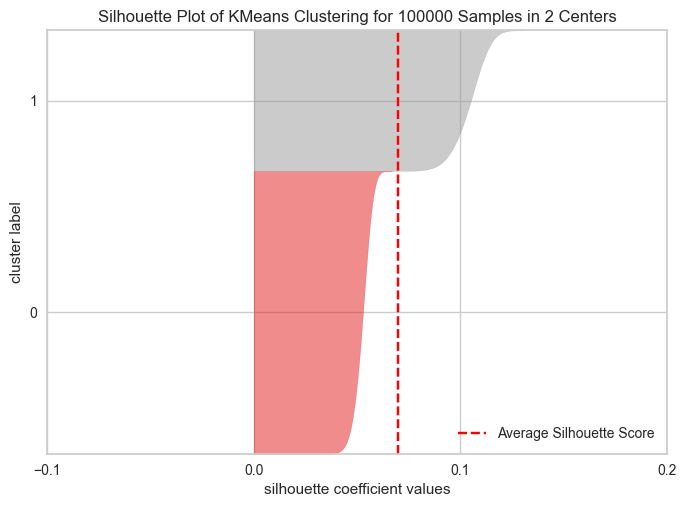

C:\Users\MOHIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


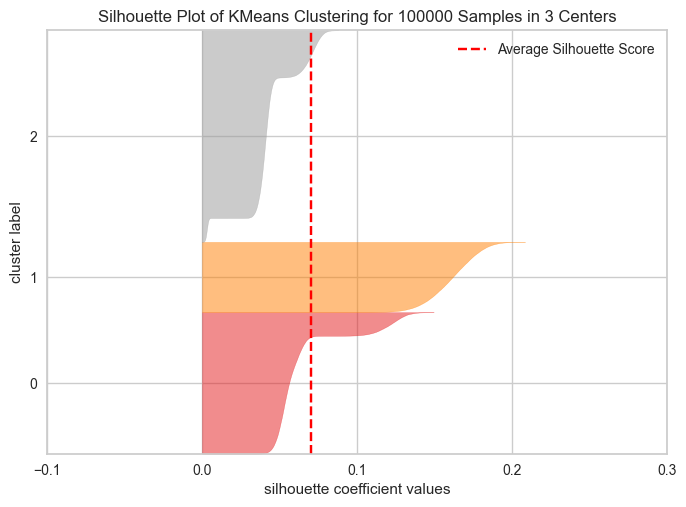

C:\Users\MOHIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


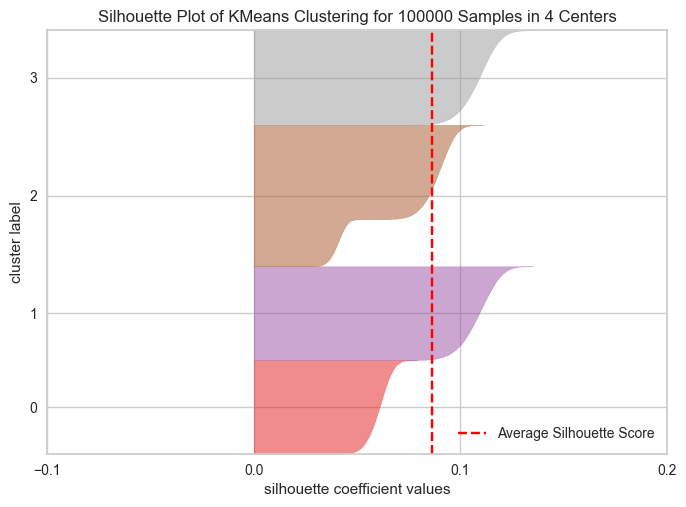

C:\Users\MOHIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


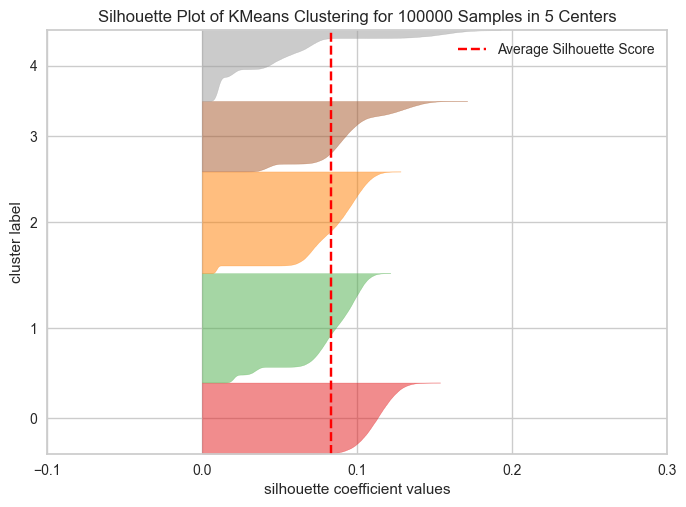

C:\Users\MOHIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


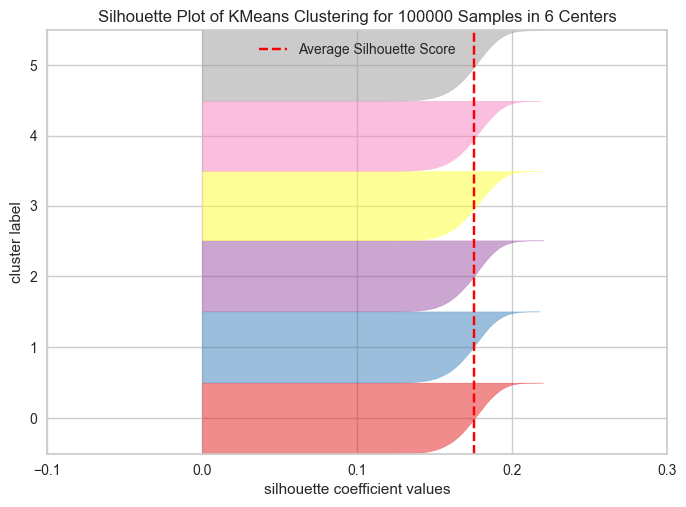

In [183]:
for i in range(2, 7):
    k = KMeans(n_clusters= i)
    k.fit(telecom)
    silhouette_visualizer(k, telecom)

Text(0, 0.5, 'WCSS Values')

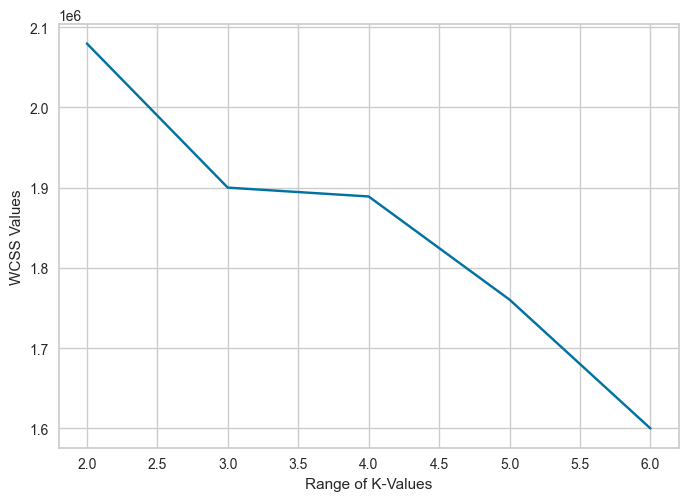

In [181]:
plt.plot(range(2,7), wcss)
plt.xlabel('Range of K-Values')
plt.ylabel('WCSS Values')